In [24]:
import os
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import pyproj
from matplotlib import pyplot
import rioxarray as rxr
from rasterstats import zonal_stats
import shapely
import psycopg2 
from sqlalchemy import create_engine

In [25]:
# Load database configuration from file
with open(r'D:\iMMAP\code\db_config\hsdc_local_db_config.json', 'r') as f:
    config = json.load(f)

# Create database URL with credentials
db_url = f"postgresql://{config['username']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

# Connect to the database
con = create_engine(db_url)

In [26]:
pd.set_option('display.max_columns', None)

In [27]:
os.chdir(r'D:\iMMAP\proj\ASDC\data\pop_admin_layer')

## Preping vector data

In [28]:
# OBS. Pop was added to admin layer prior to import
# admin_path = "SELECT * FROM afg_admbnda_adm1"  # Load from postgres
admin_sql = "select * from afg_admbnda_adm2_pop"           # Load from postgres
sett_path = r'D:\iMMAP\proj\ASDC\data\afg_pplp.shp'
build_sql = "select * from afg_buildings_microsoft_centroids" #r'D:\iMMAP\data\Afghanistan\buildings\microsoft_building_footprint.shp'

# Load data and convert to equal area projection
# admin = gpd.read_file(admin_path).to_crs('ESRI:53034') # Load shp
admin = gpd.GeoDataFrame.from_postgis(admin_sql, con).to_crs('ESRI:53034')   # Load postgres table
sett = gpd.read_file(sett_path).to_crs('ESRI:53034')
build = gpd.GeoDataFrame.from_postgis(build_sql, con).to_crs('ESRI:53034')    #gpd.read_file(build_path).to_crs('ESRI:53034')
# lc = gpd.read_file(lc_path)

In [29]:
# Set admin level column (will be used for joining and aggregations)
admin_level_column = 'adm2_pcode'

In [30]:
# Reproject and save land cover
#lc.set_crs('EPSG:32642').to_crs('ESRI:53034').to_file(r'input\land-cover-dis-sample-53034.shp')

In [31]:
# Load reprojected land cover
#lc = gpd.read_file(r'input\land-cover-dis-sample-53034.shp')

## Viewing vector data

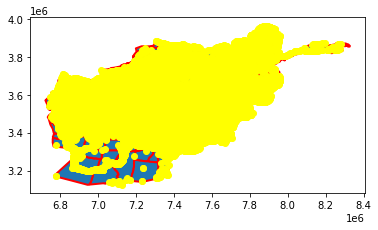

In [32]:
# View vector
ax = admin.plot(edgecolor='red', linewidth=2)
ax = sett.plot(ax=ax, color = 'yellow') #, facecolor='None', edgecolor='blue', linewidth=2)

## Area

In [33]:
# Calculating area and converting from square m to square km
admin['area_km2'] = admin['geom'].area.div(1000000)

In [34]:
#admin

## Settlements

In [35]:
# Join settlements to admin areas
joined_df = gpd.sjoin(
    sett,
    admin,
    how='inner',
    op='intersects',
)

# Count number of settlement within admin polygons
sett_count = joined_df.groupby(
    [admin_level_column],
    as_index=False,
)['vuid'].count() # vuid is arbitrary, we just count the rows

# Change column name to sett_count
sett_count.rename(columns = {'vuid': 'sett_count'}, inplace = True)

# QA Check - if any admin areas have no settlements
sett_count.isnull().sum()

# View results
#sett_count

C:\Users\VMO\anaconda3\envs\earth2\lib\site-packages\IPython\core\interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


adm2_pcode    0
sett_count    0
dtype: int64

In [36]:
# Merge sett count back on to admin dataset
admin = admin.merge(
    sett_count, 
    on=admin_level_column, 
    how='left')

#admin

## Buildings

In [37]:
## Convert building polygons to centroid points
#
## Convert building geodataframe to geoseries
#build_centroids = build.geometry
#
## Create a geoseries with just the centroids
#build_centroids = build_centroids.centroid
#
## Convert geoseries to geodataframe
#build_centroids= gpd.GeoDataFrame(build_centroids)
#
## Rename column
#build_centroids.rename(columns = {0: 'geo'}, inplace = True)
#
## Setting geometry columns specifically
#build_centroids.geometry = build_centroids['geo']

In [38]:
build_centroids = build

# Join building to admin areas
joined_df = gpd.sjoin(
    build_centroids,
    admin,
    how='inner',
    op='intersects'
)

# Count number of buildings within admin polygons
build_count = joined_df.groupby(
    [admin_level_column],
    as_index=False,
)['geom'].count() # vuid is arbitrary, we just count the rows

# Change column name to build_count
build_count.rename(columns = {'geom': 'build_count'}, inplace = True)

# QA Check - if any admin areas have no buildings
build_count.isnull().sum()

# View results
#build_count

C:\Users\VMO\anaconda3\envs\earth2\lib\site-packages\IPython\core\interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


adm2_pcode     0
build_count    0
dtype: int64

In [39]:
# Merge build count back on to admin dataset
admin = admin.merge(
    build_count, 
    on=admin_level_column, 
    how='left')

## Population Density

In [40]:
# Rename pop column
admin.rename(columns={'_sum':'pop_sum'}, inplace=True)

In [41]:
#admin

In [42]:
# Rename pop column
admin.rename(columns={'_sum': 'pop_sum'})
#df.rename(columns={"A": "a", "B": "c"})

# Calculate population density
admin['pop_density'] = admin['pop_sum'] / admin['area_km2']

# Calculate people per building
admin['people_building'] = admin['pop_sum'] / admin['build_count']

#admin

## Export results

In [43]:
# Save to shp
#"admin.to_crs('EPSG:4326').to_file(r'output/pop_adm_full.shp')
admin = admin.to_crs('EPSG:4326')

In [44]:
# Save to PostGIS
admin.to_postgis("afg_admbnda_adm2_pop_stats_v02", con)